这段代码实现了一个基于有限元法（FEM）的圆环网格划分过程，具体采用了 Q8 单元（即每个单元包含 8 个节点）。它的功能包括网格划分、节点和单元连接的创建、文件输出、以及网格模型的可视化。接下来我会逐步分析这段代码。

总节点数: 168
总单元数: 48
节点和单元文件已成功生成: nodes.txt 和 elements.txt


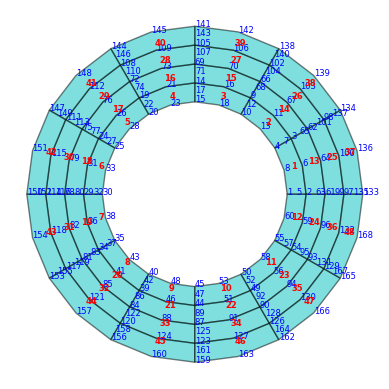

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 圆环的几何参数
X_origin = 640  # 圆心 X 坐标
Y_origin = 640  # 圆心 Y 坐标
inner_radius = 330  # 内半径
outer_radius = 600  # 外半径
NXE = 4  # 网格在 X 方向的单元数
NYE = 12  # 网格在 Y 方向的单元数
dhx = (outer_radius - inner_radius) / NXE  # 单元宽度
dhy = 2 * np.pi / NYE  # 单元角度宽度（弧度）

# 初始化全局变量
geom = []  # 节点坐标
connec = []  # 单元连接关系
nnd = 0  # 全局节点计数器
k = 0  # 全局单元计数器

# 局部函数：检查并创建节点
def check_and_create_node(x, y):
    global nnd, geom
    for nn, (gx, gy) in enumerate(geom):
        if abs(gx - x) < 1e-6 and abs(gy - y) < 1e-6:
            return nn + 1  # 如果存在，返回已有节点编号
    nnd += 1
    geom.append([x, y])  # 如果不存在，创建新节点
    return nnd

# 计算节点和单元连接
for i in range(1, NXE + 1):
    for j in range(1, NYE + 1):
        k += 1  # 单元计数器

        # 节点编号规则
        r1 = inner_radius + (i - 1) * dhx  # 当前单元的内半径
        r2 = inner_radius + i * dhx  # 当前单元的外半径

        theta1 = (j - 1) * dhy  # 当前单元的起始角度
        theta2 = j * dhy  # 当前单元的结束角度
        theta_mid = (theta1 + theta2) / 2  # 圆弧的中间角度

        # 修正角度，避免 360°（2*pi）重复
        if abs(theta1 - 2 * np.pi) < 1e-6:
            theta1 = 0
        if abs(theta2 - 2 * np.pi) < 1e-6:
            theta2 = 0
        if abs(theta_mid - 2 * np.pi) < 1e-6:
            theta_mid = 0

        # 检查并创建节点
        # 创建Q8单元的4个角点
        n1 = check_and_create_node(r1 * np.cos(theta1) + X_origin, r1 * np.sin(theta1) + Y_origin)
        n3 = check_and_create_node(r2 * np.cos(theta1) + X_origin, r2 * np.sin(theta1) + Y_origin)
        n5 = check_and_create_node(r2 * np.cos(theta2) + X_origin, r2 * np.sin(theta2) + Y_origin)
        n7 = check_and_create_node(r1 * np.cos(theta2) + X_origin, r1 * np.sin(theta2) + Y_origin)
        # # 创建Q8单元的4个中间点
        # 节点2是节点1和节点3的中点，径向方向，同理节点6
        # 节点4计算，改为弧形曲边的中点，同理节点8
        n2 = check_and_create_node((geom[n1 - 1][0] + geom[n3 - 1][0]) / 2, (geom[n1 - 1][1] + geom[n3 - 1][1]) / 2)
        n4 = check_and_create_node(r2 * np.cos(theta_mid) + X_origin, r2 * np.sin(theta_mid) + Y_origin)
        n6 = check_and_create_node((geom[n5 - 1][0] + geom[n7 - 1][0]) / 2, (geom[n5 - 1][1] + geom[n7 - 1][1]) / 2)
        n8 = check_and_create_node(r1 * np.cos(theta_mid) + X_origin, r1 * np.sin(theta_mid) + Y_origin)

        # 生成单元连接关系
        connec.append([n1, n2, n3, n4, n5, n6, n7, n8])

# 输出结果检查
print(f'总节点数: {nnd}')
print(f'总单元数: {k}')

# 节点和单元文件写入
node_file = 'nodes.txt'  # 节点文件
element_file = 'elements.txt'  # 单元文件

# 写入节点文件
with open(node_file, 'w') as fid_nodes:
    for i, (x, y) in enumerate(geom, start=1):
        fid_nodes.write(f'{i}, {x:.6f}, {y:.6f}\n')

# 写入单元文件
with open(element_file, 'w') as fid_elements:
    for i, conn in enumerate(connec, start=1):
        conn = [conn[idx - 1] for idx in [1, 3, 5, 7, 2, 4, 6, 8]]
        fid_elements.write(f'{i}, ' + ', '.join(map(str, conn)) + '\n')

print('节点和单元文件已成功生成: nodes.txt 和 elements.txt')

# 绘制圆环网格模型
geom = np.array(geom)
connec = np.array(connec) - 1  # 转换为零索引
plt.figure('圆环Q8单元有限元网格模型')
plt.gca().set_aspect('equal', adjustable='box')
for elem in connec:
    plt.fill(geom[elem, 0], geom[elem, 1], edgecolor='k', facecolor='c', alpha=0.5)

# 显示节点编号
for i, (x, y) in enumerate(geom, start=1):
    plt.text(x, y, str(i), fontsize=6, color='blue')

# 显示单元编号
for j, elem in enumerate(connec, start=1):
    center_x = np.mean(geom[elem, 0])
    center_y = np.mean(geom[elem, 1])
    plt.text(center_x, center_y, str(j), fontsize=6, color='red', fontweight='bold')

plt.axis('off')
plt.show()

In [51]:
def get_integer_points_of_element(nodes, center):
    """
    输入: nodes 为一个 8x2 矩阵, 表示单元的8个节点坐标 (x, y)
    输出：返回一个 Nx2 矩阵，包含所有整数坐标点
    8个节点的顺序为:
    逆时针方向: 首先4个角点, 其次四个中间点
    """
    
    # 提取节点的 x 和 y 坐标
    x_coords = nodes[:, 0]
    y_coords = nodes[:, 1]
    center_x, center_y = center

    # 计算内外半径
    inner_radius = np.min(np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2))  # 内半径
    outer_radius = np.max(np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2))  # 外半径
    # 计算左右边界角度
    angle_nodes = np.arctan2(y_coords - center_y, x_coords - center_x)  # 计算每个节点的角度
    # 将角度转换到 [0, 2*pi] 范围内
    angle_nodes[angle_nodes < 0] += 2 * np.pi
    left_angle =  np.min(angle_nodes)  # 左边界角度
    right_angle = np.max(angle_nodes)  # 右边界角度
    flag = 0  # 标志变量，判断是否跨越 0 度线, 0表示没有跨越，1表示跨越
    if right_angle - left_angle > np.pi:
        # 如果左边界角度大于右边界角度，说明跨越了 0 度线，需要调整
        flag = 1
        left_angle  = np.min(np.arctan2(y_coords - center_y, x_coords - center_x))
        right_angle = np.max(np.arctan2(y_coords - center_y, x_coords - center_x))

    # print(f'左边界角度: {left_angle}, 右边界角度: {right_angle}')

    # 确定单元的最小和最大 x，y 坐标范围
    min_x = np.floor(np.min(x_coords))
    max_x = np.ceil(np.max(x_coords))
    min_y = np.floor(np.min(y_coords))
    max_y = np.ceil(np.max(y_coords))

    # 生成单元内的网格（通过网格化 x 和 y 方向的坐标）
    x_grid, y_grid = np.meshgrid(np.arange(min_x, max_x + 1), np.arange(min_y, max_y + 1))
    grid_points = np.vstack((x_grid.ravel(), y_grid.ravel())).T  # 转换为 Nx2 矩阵
    radius = np.sqrt((grid_points[:, 0] - center_x)**2 + (grid_points[:, 1] - center_y)**2)  # 计算每个点到圆心的距离
    angles = np.arctan2(grid_points[:, 1] - center_y, grid_points[:, 0] - center_x)  # 计算每个点的角度
    # 将角度转换到 [0, 2*pi] 范围内
    if flag == 0:
        angles[angles < 0] += 2 * np.pi
    # 过滤出在圆环内的整数点
    valid_points = np.logical_and(radius >= inner_radius, radius <= outer_radius)  # 在圆环内的点
    angle_valid = np.logical_and(angles >= left_angle, angles <= right_angle)  # 在角度范围内的点
    valid_points = np.logical_and(valid_points, angle_valid)  # 综合条件
    integer_points = grid_points[valid_points]  # 获取符合条件的整数点坐标
    return np.array(integer_points)


In [52]:
r1 = inner_radius   # 内半径
r2 = outer_radius   # 外半径
Cx = X_origin       # 图像中心X坐标
Cy = Y_origin       # 图像中心Y坐标
d1 = 1280           # 图像宽度
d2 = 1280           # 图像高度

# 读取节点和单元数据
node = np.loadtxt('nodes.txt', delimiter=',')  # 第一列为节点，第二列和第三列为坐标，单位是像素
element = np.loadtxt('elements.txt', delimiter=',', dtype=int)  # 第一列为单元编号，后边8列为该单元的节点
node_num = node.shape[0]  # 节点数量
element_num = element.shape[0]  # 单元数量

# 用于存储像素点和单元的关系
Inform = []
# 遍历所有单元中的像素点
for i in range(element_num):
    # 获取单元的节点坐标
    nodes = node[element[i, 1:]-1, 1:3]  # 获取该单元的8个节点坐标
    # 获取该单元内的整数点
    integer_points = get_integer_points_of_element(nodes, center=[Cx, Cy])
    # 将整数点和单元编号存储到 Inform 中
    for point in integer_points:
        Inform.append([point[0], point[1], i + 1])  # 注意单元编号从1开始
# 将 Inform 转换为 NumPy 数组
Inform = np.array(Inform)
# 保存 Inform 到 .npy 文件
np.save('Inform.npy', Inform)


In [50]:
nodes = node[element[11, 1:]-1, 1:3]  # 获取该单元的8个节点坐标
integer_points = get_integer_points_of_element(nodes, center=[Cx, Cy])
integer_points

左边界角度: -0.5235987759753667, 右边界角度: 0.0


array([[ 983.,  442.],
       [ 984.,  442.],
       [ 982.,  443.],
       ...,
       [1035.,  640.],
       [1036.,  640.],
       [1037.,  640.]])

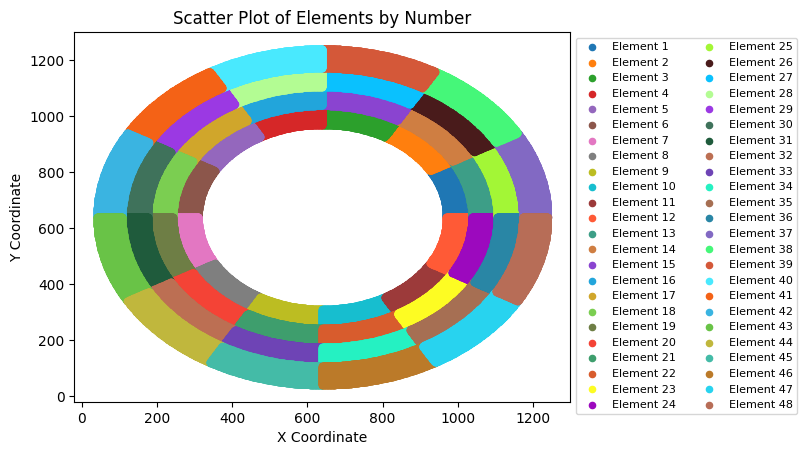

In [57]:
# 加载数据
Inform = np.load('Inform.npy')  # 读取 .npy 文件

# 初始化一个列表来存储不同编号的元素
numElements = int(np.max(Inform[:, 2]))  # 找到最大的单元编号
elements = [[] for _ in range(numElements)]  # 初始化一个空的列表，大小为 numElements

# 遍历 Inform 数组，将元素按编号存储到列表中
for row in Inform:
    num = int(row[2])  # 获取当前元素的编号
    elements[num - 1].append(row[:2])  # 存储元素（注意：这里我们也将编号存储了，以便后续使用）

fixed_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#9c3a3a", "#ff5a36", "#3d9e87", "#cf7e42", "#8a44d0", "#22a5db", "#d0a62b", "#7bce51", "#6e7e45", "#f44336",
    "#3e9e6d", "#d85c2d", "#fdfc23", "#9c09be", "#a3f636", "#491b1b", "#0ac1fe", "#b3fc93", "#9b39e3", "#3f725b",
    "#1f5b3c", "#bc6f53", "#6e44b5", "#25f1c2", "#a66f53", "#2986a5", "#8269c3", "#45f779", "#d45839", "#49e9fe",
    "#f46216", "#3ab4e1", "#69c347", "#c0b73d", "#44bba7", "#bb7a29", "#28d3ef", "#b76d57", "#c3b4db", "#c8bcb4"
]

# 绘制散点图
plt.figure()
colors = plt.cm.viridis(np.linspace(0, 1, numElements))  # 获取一个颜色数组，用于不同编号的元素
for num in range(numElements):
    if len(elements[num]) > 0:  # 检查该编号的元素是否存在
        elements_num = np.array(elements[num])  # 转换为 NumPy 数组
        color_idx = num % len(fixed_colors)
        plt.scatter(elements_num[:, 0], elements_num[:, 1], s=20, c=[fixed_colors[color_idx]], label=f'Element {num + 1}')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Elements by Number')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize=8)
plt.show()

In [58]:
Inform

array([[9.700e+02, 6.400e+02, 1.000e+00],
       [9.710e+02, 6.400e+02, 1.000e+00],
       [9.720e+02, 6.400e+02, 1.000e+00],
       ...,
       [1.238e+03, 6.400e+02, 4.800e+01],
       [1.239e+03, 6.400e+02, 4.800e+01],
       [1.240e+03, 6.400e+02, 4.800e+01]])